Import Modules

In [6]:
from keras.backend import concatenate
import numpy as np
from pandas import read_csv, DataFrame, concat
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Masking, Bidirectional, Dense
from keras.layers.core import Dropout
from scipy.sparse import data
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
import plotly.graph_objects as go

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls "/content/drive/My Drive/Amol/dataset"

points2.csv  points3.csv  points.csv


Constants

In [8]:
FILENAME = "/content/drive/My Drive/Amol/dataset/points.csv"
TRAIN_DATASET_RATIO = 0.8
KEY = 1

Functions

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def find_rmse(X, Y, pred):
  # make a prediction
  X = X.reshape((X.shape[0], X.shape[2]))
  X = X[: , -3: ]

  # invert scaling for forecast
  inv_yhat = np.concatenate((pred, X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # invert scaling for actual
  Y = Y.reshape((len(Y), 1))
  inv_y = np.concatenate((Y, X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  # calculate RMSE
  rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
  return rmse

Load Dataset

In [10]:
#fix random seed for reproducibility
np.random.seed(7)

# load dataset
dataset = read_csv(FILENAME, header=None)
dataset = dataset.values
dataset = dataset.astype('float32')
n_features = dataset.shape[1]
features = {('var%d' % (i+1)): i for i in range(n_features)}

Prepare Dataset

In [11]:
# Feature to model
feature_to_model = list(features.keys())[KEY]
del features[feature_to_model]
columns_to_drop = [(i-n_features) for i in features.values()]

# normalize the dataset
lookback = 4
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(dataset)

reframed = series_to_supervised(scaled, lookback)

reframed.drop(reframed.columns[columns_to_drop], axis=1, inplace=True)

#split into train and test data
values = reframed.values
train_data_range = int(len(values)*TRAIN_DATASET_RATIO)
train = values[:train_data_range, :]
test = values[train_data_range:, :]

# split into inputs and outputs
train_X, train_Y = train[:, :-1], train[:, -1]
test_X, test_Y = test[:, :-1], test[:, -1]

# reshape into 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Design Network

In [12]:
# design Network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

checkpoint = ModelCheckpoint('LSTMyearly.h5', monitor ='loss'
    , verbose = 1, savebestonly = True, saveweightsonly =False, 
    mode ='auto', period = 1)
callbackslist = [checkpoint]

# fit network
history = model.fit(train_X, train_Y, epochs=30, 
    batch_size=64, validation_data=(test_X, test_Y), 
    verbose=2, shuffle=False, callbacks= callbackslist)

Epoch 1/30
58/58 - 21s - loss: 0.1514 - mae: 0.3286 - val_loss: 0.0611 - val_mae: 0.1864

Epoch 00001: saving model to LSTMyearly.h5
Epoch 2/30
58/58 - 0s - loss: 0.0307 - mae: 0.1357 - val_loss: 0.0284 - val_mae: 0.1299

Epoch 00002: saving model to LSTMyearly.h5
Epoch 3/30
58/58 - 0s - loss: 0.0151 - mae: 0.0896 - val_loss: 0.0167 - val_mae: 0.1026

Epoch 00003: saving model to LSTMyearly.h5
Epoch 4/30
58/58 - 0s - loss: 0.0099 - mae: 0.0725 - val_loss: 0.0100 - val_mae: 0.0817

Epoch 00004: saving model to LSTMyearly.h5
Epoch 5/30
58/58 - 0s - loss: 0.0064 - mae: 0.0580 - val_loss: 0.0063 - val_mae: 0.0645

Epoch 00005: saving model to LSTMyearly.h5
Epoch 6/30
58/58 - 0s - loss: 0.0042 - mae: 0.0461 - val_loss: 0.0043 - val_mae: 0.0515

Epoch 00006: saving model to LSTMyearly.h5
Epoch 7/30
58/58 - 0s - loss: 0.0030 - mae: 0.0374 - val_loss: 0.0032 - val_mae: 0.0426

Epoch 00007: saving model to LSTMyearly.h5
Epoch 8/30
58/58 - 0s - loss: 0.0022 - mae: 0.0317 - val_loss: 0.0025 - val

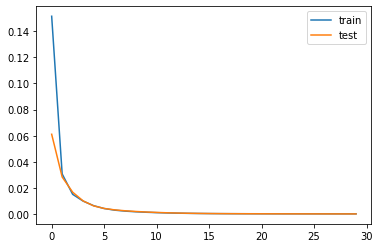

In [13]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Make Predictions

In [14]:
# make predictions
yhat_train = model.predict(train_X)
yhat_test = model.predict(test_X)

Reshape datasets

In [15]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
train_X = train_X[: , -n_features: ]

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X = test_X[:, -n_features: ]

# invert scaling for forecast
inv_yhat_train = np.concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

inv_yhat_test = np.concatenate((yhat_test, test_X[:, 1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:, 0]

# invert scaling for actual
train_Y = train_Y.reshape((len(train_Y), 1))
inv_Y_train = np.concatenate((train_Y, train_X[:, 1:]), axis=1)
inv_Y_train = scaler.inverse_transform(inv_Y_train)
inv_Y_train = inv_Y_train[:, 0]

test_Y = test_Y.reshape((len(test_Y), 1))
inv_Y_test = np.concatenate((test_Y, test_X[:, 1:]), axis=1)
inv_Y_test = scaler.inverse_transform(inv_Y_test)
inv_Y_test = inv_Y_test[:,0]

Find RMSE

In [16]:
# calculate RMSE
train_rmse = math.sqrt(mean_squared_error(inv_Y_train, inv_yhat_train))
test_rmse = math.sqrt(mean_squared_error(inv_Y_test, inv_yhat_test))

print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % test_rmse)

Train RMSE: 0.228
Test RMSE: 0.181


Plot Lorenz

In [17]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(dataset[:, 0], dataset[:, 1], dataset[:, 2], 'red')
#plt.draw()
#plt.show()

final_pred = (concatenate((dataset[:lookback, KEY],inv_yhat_train, inv_yhat_test), 
    axis=0)).numpy()
final_pred.reshape((len(final_pred)))
x = dataset[:, 0] if KEY != 0 else final_pred
y = dataset[:, 1] if KEY != 1 else final_pred
z = dataset[:, 2] if KEY != 2 else final_pred
fig1 = go.Figure(data=go.Scatter3d(
  x = x, y = y, z = z,
    line=dict(
      color = 'darkblue',
      width=1
    ),
    marker=dict(
      size=0.0001
    )
  ))
fig1.show(renderer="colab")


#ax.plot3D(final_pred, dataset[:, 1], dataset[:, 2], 'red')
#plt.draw()

Scatter Plot Prediction of coordinate

In [18]:
fig2 = px.line(title = ('Trajectory of Lorenz solution for %s' % feature_to_model))
fig2.add_scatter(x=[*range(0, len(inv_yhat_train)-1, 1)],y=inv_yhat_train, 
    name=('%s-train' % feature_to_model))
fig2.add_scatter(y=dataset[:, 1].reshape(len(dataset[:, 1])), 
    name=('%s-actual' % feature_to_model))
fig2.add_scatter( x=[*range(len(inv_yhat_train)-1, len(inv_yhat_train)+len(inv_yhat_test)-1, 1)], y=inv_yhat_test, 
    name=('%s-test' % feature_to_model))
fig2.show(renderer="colab")

Original Lorenz Plot

In [19]:
fig3 = go.Figure(data=go.Scatter3d(
    x = dataset[:, 0], y = dataset[:, 1], z = dataset[:, 2],
    line=dict(
      color = 'darkblue',
      width=1
    ),
    marker=dict(
      size=0.0001
    )
  ))
fig3.show(renderer="colab")